In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)

# Torch check, remove if you dont need it
# I ran this before upgrading to 12

2.5.1
11.8


In [2]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter # Removed .filters
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from scipy import ndimage, spatial
%matplotlib inline

In [29]:
# Owing to a late-found MAE issue, this has been rewritten to move the normalization to the end; total sum accidentally in loop
# There are a few versions of this function, see paper for explanation: original CSRNet code wouldnt work with our annotation formulation
# I was unable to recreate the Matlab format they used for annotations
def gaussian_filter_density(img_shape, gt_x, gt_y, radii, scale_radius=1.0): # scale radius was not used in the end, used in earlier versions

    # Initialize empty density map
    density = np.zeros(img_shape, dtype=np.float32)

    H, W = img_shape 

    # Loop over each annotation point
    for x, y, r in zip(gt_x, gt_y, rad): # for each ground truth x coord y coord and radius
        # Calculate sigma for current point
        sigma = r * scale_radius
        if sigma <= 0:
            # Skip points with zero/negative sigma, issue with earlier version
            continue

        # Kernel size: roughly 6 x sigma, force it to be odd
        kernel_size = int(np.ceil(6 * sigma))
        if kernel_size % 2 == 0: # check if its even
            kernel_size += 1
        c = kernel_size // 2  # Radius of kernel

        # Generate the Gaussian kernel
        coords = np.arange(kernel_size) - c
        xv, yv = np.meshgrid(coords, coords)
        gaussian = np.exp(-(xv**2 + yv**2) / (2 * sigma**2))

        # Place the Gaussian
        x_min = int(np.floor(x)) - c
        x_max = x_min + kernel_size
        y_min = int(np.floor(y)) - c
        y_max = y_min + kernel_size

        # Clamp to image boundaries
        gauss_x_start = 0
        gauss_y_start = 0

        # Make sure kernel is inside image boundary
        if x_min < 0:
            gauss_x_start = -x_min
            x_min = 0
        if y_min < 0:
            gauss_y_start = -y_min
            y_min = 0
        if x_max > W:
            x_max = W
        if y_max > H:
            y_max = H

        # Compute the region size
        H_region = y_max - y_min
        W_region = x_max - x_min

        # With above, sets the Gaussian region
        gauss_x_end = gauss_x_start + W_region
        gauss_y_end = gauss_y_start + H_region

        # Ensure we have something to add
        if H_region > 0 and W_region > 0 and \
           gauss_x_end > gauss_x_start and gauss_y_end > gauss_y_start:

            # Create the appropriate sub-region into density
            density[y_min:y_max, x_min:x_max] += \
                gaussian[gauss_y_start:gauss_y_end, gauss_x_start:gauss_x_end]

    #   Many crowd-counting pipelines scale the map so that sum(density) = number_of_points
    total_sum = density.sum()
    num_points = len(gt_x)
    if total_sum > 0 and num_points > 0:
        density *= (num_points / total_sum)

    return density

In [4]:
root = r'processed_dataset_route'
train = os.path.join(root, 'train', 'images')
test = os.path.join(root, 'test', 'images')

In [5]:
img_paths = []
for path in [train, test]:
    img_paths.extend(glob.glob(os.path.join(path, '*.png')))

In [11]:
# To find keys in .h5 files, validation of previous step
example_h5_path = r'example_h5'
with h5py.File(example_h5_path, 'r') as f:
    print("Keys in .h5 file:", list(f.keys()))


Keys in .h5 file: ['#item', 'c-x', 'c-y', 'density', 'radius']


In [30]:
# This makes the heatmaps
for img_path in img_paths: # iterates over root, replacing as and when needed
    print(img_path)
    
    # Still including the hr check, left in because it doesn't hurt
    if "hr" in img_path:
        h5_path = img_path.replace("hr.png", ".h5").replace("images", "ground_truth")
    else:
        h5_path = img_path.replace(".png", ".h5").replace("images", "ground_truth")
    
    # Check if the .h5 file exists, again this shouldn't be an issue if previous notebooks completed successfully
    if not os.path.exists(h5_path):
        print(f"File not found: {h5_path}")
        continue

    # Get the info needed
    with h5py.File(h5_path, 'r') as hf:
        if 'c-x' in hf.keys() and 'c-y' in hf.keys():
            gt_x = hf['c-x'][:].astype(np.float32)  # Ensure c-x values are floats, this can cause trouble
            gt_y = hf['c-y'][:].astype(np.float32)  # Ensure c-y values are floats
        if 'radius' in hf.keys():
            radii = hf['radius'][:].astype(np.float32)  # Ensure radius values are floats
            if np.isscalar(radii):  # If radii is a scalar, make it an array. This can also be an issue
                radii = np.full_like(gt_x, radii, dtype=np.float32)
            else:
                radii = np.full_like(gt_x, 10, dtype=np.float32)  # Default radius if none available
        else:
            print(f"No records found in: {h5_path}")
            continue

    # Required image shape
    img = plt.imread(img_path)
    img_shape = img.shape[:2]

    # Generate density map with data points collected above
    density_map = gaussian_filter_density(img_shape, gt_x, gt_y, radii, scale_radius=1.0)  # Adjust scale_radius, set to 2 in previous versions

    # Save the density map back to an .h5 file without overwriting other keys
    with h5py.File(h5_path, 'a') as hf:
        if 'density' in hf:
            del hf['density']  # Delete existing 'density' value, required if re-running
        hf.create_dataset('density', data=density_map)  # Add the new 'density' dataset

D:\AI\CSRNet\dataset\train\images\20130320T004348.754118.Cam6_13.png
D:\AI\CSRNet\dataset\train\images\20130320T004349.516008.Cam6_43.png
D:\AI\CSRNet\dataset\train\images\20130320T004351.039789.Cam6_32.png
D:\AI\CSRNet\dataset\train\images\20130320T004351.801805.Cam6_43.png
D:\AI\CSRNet\dataset\train\images\20130320T004351.992184.Cam6_61.png
D:\AI\CSRNet\dataset\train\images\20130320T004352.373192.Cam6_51.png
D:\AI\CSRNet\dataset\train\images\20130320T004352.754200.Cam6_23.png
D:\AI\CSRNet\dataset\train\images\20130320T004353.135082.Cam6_53.png
D:\AI\CSRNet\dataset\train\images\20130320T004354.277980.Cam6_41.png
D:\AI\CSRNet\dataset\train\images\20130320T004354.849492.Cam6_52.png
D:\AI\CSRNet\dataset\train\images\20130320T004355.801761.Cam6_12.png
D:\AI\CSRNet\dataset\train\images\20130320T004356.563776.Cam6_42.png
D:\AI\CSRNet\dataset\train\images\20130320T004357.135163.Cam6_61.png
D:\AI\CSRNet\dataset\train\images\20130320T004357.897055.Cam6_21.png
D:\AI\CSRNet\dataset\train\images\

``` .h5 ``` should now be around 200kb in size.

## Debugging

Is there a density map that matches its image?

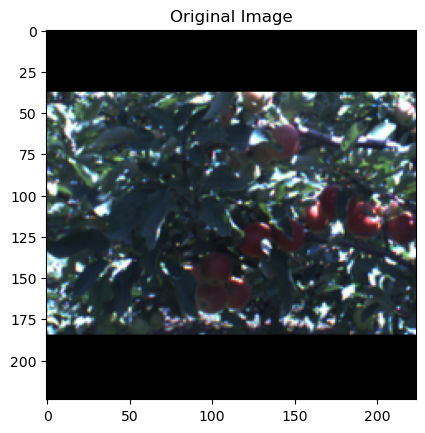

Keys in the .h5 file: ['#item', 'c-x', 'c-y', 'density', 'radius']
Using 'density' key.
Density map shape: (224, 224)
Density map sum: 12.999999


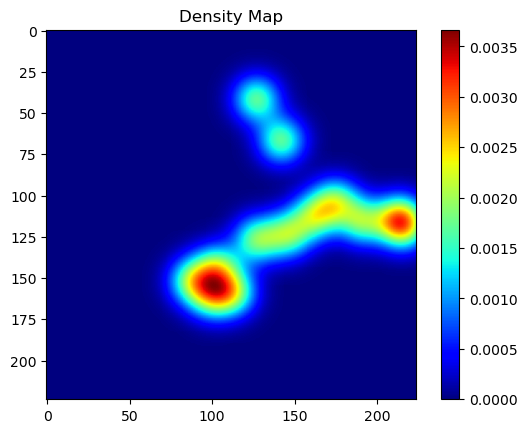

In [33]:
# Display the image
img_path = img_paths[100]  # Example: view the 100th image
plt.imshow(Image.open(img_path))
plt.title("Original Image")
plt.show()

# Get the appropriate .h5 file
h5_path = img_path.replace('.png', '.h5').replace('images', 'ground_truth')

with h5py.File(h5_path, 'r') as gt_file:
    # List all keys in the .h5 file, sanity check
    print("Keys in the .h5 file:", list(gt_file.keys()))

    # Check if 'density' or 'density_map' dataset exists; previous function used density_map
    if 'density' in gt_file:
        density_map = gt_file['density'][:]
        print("Using 'density' key.")
    elif 'density_map' in gt_file:
        density_map = gt_file['density_map'][:]
        print("Using 'density_map' key.")
    else:
        print("No 'density' or 'density_map' key found in the .h5 file.")
        density_map = None

    if density_map is not None:
        print("Density map shape:", density_map.shape)
        print("Density map sum:", np.sum(density_map))  # Sum should be > 0 if there's data

        if np.sum(density_map) > 0:
            plt.imshow(density_map, cmap = 'jet')
            plt.colorbar()
            plt.title("Density Map")
            plt.show()
        else:
            print("The density map is empty.")

### Key's check for .h5

In [34]:
# Another check!
with h5py.File(h5_path, 'r') as hf:
    print("Keys in the .h5 file:", list(hf.keys()))

Keys in the .h5 file: ['#item', 'c-x', 'c-y', 'density', 'radius']


## .h5 verification

In [19]:
# Path to the ground_truth folder for train
ground_truth_dir = r'train_ground_truth_directory'

missing_density = []
for h5_file in os.listdir(ground_truth_dir):
    if h5_file.endswith(".h5"):
        h5_path = os.path.join(ground_truth_dir, h5_file)
        with h5py.File(h5_path, 'r') as f:
            if 'density' not in f:
                missing_density.append(h5_file)

if missing_density:
    print("The following files are missing the 'density' dataset:")
    for filename in missing_density:
        print(filename)
else:
    print("All .h5 files contain the 'density' dataset.") # This is the one you want to see


All .h5 files contain the 'density' dataset.


In [20]:
# Path to the ground_truth folder for test
ground_truth_dir = r'test_ground_truth_directory'

missing_density = []
for h5_file in os.listdir(ground_truth_dir):
    if h5_file.endswith(".h5"):
        h5_path = os.path.join(ground_truth_dir, h5_file)
        with h5py.File(h5_path, 'r') as f:
            if 'density' not in f:
                missing_density.append(h5_file)

if missing_density:
    print("The following files are missing the 'density' dataset:")
    for filename in missing_density:
        print(filename)
else:
    print("All .h5 files contain the 'density' dataset.") # This is the one you want to see

All .h5 files contain the 'density' dataset.
